<h1>Importing Libraries</h1>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from glob import glob
from PIL import Image
import keras
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

<h1>Getting metadata and images path</h1>

In [2]:
base_skin_dir = os.path.join('.', 'content') # Both images and metadata are in ./input

base_skin_dir

'.\\content'

In [ ]:
# Merging all images from the two folders into one dict

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

type(imageid_path_dict)

In [ ]:
# Loadind the metadata as a pd dataframe

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df.head(10)

<h1>EDA</h1>

In [ ]:
# Checking class distribution

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['dx'].value_counts().plot(color='m', kind='bar', ax=ax1)

In [ ]:
# Checking region of the lesions distribution

skin_df['localization'].value_counts().plot(color='m', kind='bar')

In [ ]:
# Cheking age distribution

skin_df['age'].hist(color='m', bins=40)

In [ ]:
# Cheking sex distribution

skin_df['sex'].value_counts().plot(color='m', kind='bar')

<h1>Pre-Processing</h1>

<h2>Features Processing</h2>

In [ ]:
# Filling the unknown instances with the predominant feature
skin_df['sex'] = skin_df['sex'].replace('unknown', 'male')

# Plot again to see the change
skin_df['sex'].value_counts().plot(color='m', kind='bar')

In [ ]:
skin_df.sample(10)

In [ ]:
# Creating a column to help on linking an instance to an image, using its path

skin_df['image_path'] = skin_df['image_id'].map(imageid_path_dict.get)

In [ ]:
# Converting the label from categorical to numeric

skin_df['lesion_type'] = pd.Categorical(skin_df['dx']).codes

In [ ]:
# Dropping useless features, such as ids

skin_df = skin_df.drop(columns=['image_id', 'lesion_id', 'dx', 'dx_type'])

In [ ]:
# Checking samples from the new df

skin_df.sample(10)

In [ ]:
# Checking for null values

skin_df.isnull().sum()

In [ ]:
# Filling the null values by the columns mean and truncating

skin_df['age'].fillna(int((skin_df['age'].mean())), inplace=True)
np.array_equal(skin_df.age, skin_df.age.astype(int))

In [ ]:
# No more null values

skin_df.isnull().sum()

In [ ]:
# Converting floating age values to int and print resulting df

skin_df.age = skin_df.age.astype(int)
skin_df.head()

In [ ]:
# Loading the images to the df using its path
skin_df['image'] = skin_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

# Dropping the now useless path column
skin_df = skin_df.drop(columns=['image_path'])
skin_df.head()

<h2>Image Preprocessing</h2>

In [3]:
# Dump all images into a folder and specify the path:
data_dir = os.getcwd() + "\\content\\all_images\\"

# Path to destination directory where we want subfolders
dest_dir = os.getcwd() + "\\content\\reorganized\\"

print(data_dir + "\n" + dest_dir)

C:\Users\luis.vb\Desktop\ham10000\content\all_images\
C:\Users\luis.vb\Desktop\ham10000\content\reorganized\


In [4]:
skin_df2 = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
print(skin_df2['dx'].value_counts())

label=skin_df2['dx'].unique().tolist()  #Extract labels into a list
label_images = []

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [5]:
# Copy images to new folders
for i in label:
    os.mkdir(dest_dir + str(i) + "\\")
    sample = skin_df2[skin_df2['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + "\\"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
    label_images=[]  

In [1]:
#no risk - bkl df nv vasc
#risk - akiec bcc mel

In [17]:
#create two folders (train and validation)
train_dir = os.path.join(base_skin_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_skin_dir, 'validation')
os.mkdir(validation_dir)

print(train_dir + "\n" + validation_dir)

.\content\train
.\content\validation


In [18]:
# Under train folder create seven folders 
# (nv, mel, bkl, bcc, akiec, vasc, df) to (risk and norisk)

train_risk_dir = os.path.join(train_dir, 'risk')
os.mkdir(train_risk_dir)

train_norisk_dir = os.path.join(train_dir, 'norisk')
os.mkdir(train_norisk_dir)

#Under validation folder create seven folders 
# (nv, mel, bkl, bcc, akiec, vasc, df) to (risk and norisk)

validation_risk_dir = os.path.join(validation_dir, 'risk')
os.mkdir(validation_risk_dir)

validation_norisk_dir = os.path.join(validation_dir, 'norisk')
os.mkdir(validation_norisk_dir)

In [19]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)

In [20]:
RISK_SOURCE_DIR = '\\content\\reorganized\\risk\\'
TRAINING_RISK_DIR = '\\content\\train\\risk\\'
VALID_RISK_DIR = '\\content\\validation\\risk\\'

NORISK_SOURCE_DIR = '\\content\\reorganized\\norisk\\'
TRAINING_NORISK_DIR = '\\content\\train\\norisk\\'
VALID_NORISK_DIR = '\\content\\validation\\norisk\\'

In [21]:
from shutil import copyfile
import random

split_size = .80

split_data(os.getcwd() + RISK_SOURCE_DIR, os.getcwd() + TRAINING_RISK_DIR, os.getcwd() + VALID_RISK_DIR, split_size)
split_data(os.getcwd() + NORISK_SOURCE_DIR, os.getcwd() + TRAINING_NORISK_DIR, os.getcwd() + VALID_NORISK_DIR, split_size)

<h2>Undersample</h2>

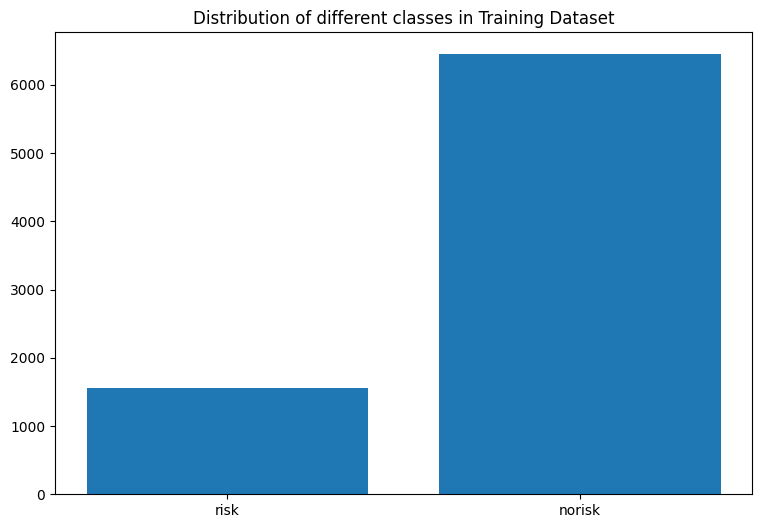

In [22]:
import seaborn as sns
from matplotlib.image import imread
import pathlib

image_folder = ['risk', 'norisk']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir(os.getcwd() + '\\content\\train\\'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

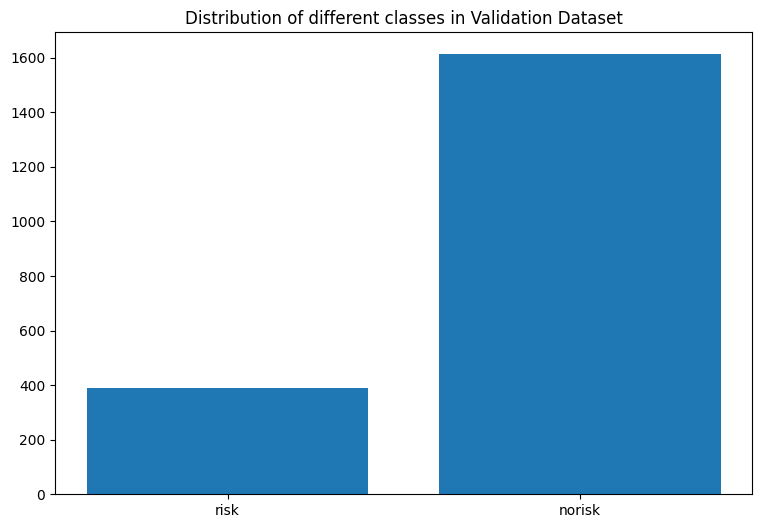

In [23]:
image_folder = ['risk', 'norisk']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir(os.getcwd() + '\\content\\validation\\'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Validation Dataset')
plt.show()

In [24]:
def undersample_images(directory, target_count):
    # Lista todos os arquivos no diretório
    images = [file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]
    
    # Calcula quantas imagens precisam ser removidas
    images_to_remove_count = len(images) - target_count

    if images_to_remove_count > 0:
        # Escolhe aleatoriamente as imagens a serem removidas
        images_to_remove = random.sample(images, images_to_remove_count)

        # Remove as imagens selecionadas
        for image in images_to_remove:
            os.remove(os.path.join(directory, image))
            print(f"Imagem {image} removida.")

    else:
        print("Não é necessário remover imagens.")

undersample_images(os.getcwd() + '\\content\\train\\norisk\\', 1600)

Imagem ISIC_0030853.jpg removida.
Imagem ISIC_0034318.jpg removida.
Imagem ISIC_0029356.jpg removida.
Imagem ISIC_0029023.jpg removida.
Imagem ISIC_0030498.jpg removida.
Imagem ISIC_0024770.jpg removida.
Imagem ISIC_0027877.jpg removida.
Imagem ISIC_0033305.jpg removida.
Imagem ISIC_0030680.jpg removida.
Imagem ISIC_0030057.jpg removida.
Imagem ISIC_0029255.jpg removida.
Imagem ISIC_0033859.jpg removida.
Imagem ISIC_0028833.jpg removida.
Imagem ISIC_0033529.jpg removida.
Imagem ISIC_0030334.jpg removida.
Imagem ISIC_0031624.jpg removida.
Imagem ISIC_0024383.jpg removida.
Imagem ISIC_0026146.jpg removida.
Imagem ISIC_0029789.jpg removida.
Imagem ISIC_0027499.jpg removida.
Imagem ISIC_0031714.jpg removida.
Imagem ISIC_0031124.jpg removida.
Imagem ISIC_0033740.jpg removida.
Imagem ISIC_0030095.jpg removida.
Imagem ISIC_0028913.jpg removida.
Imagem ISIC_0028951.jpg removida.
Imagem ISIC_0032780.jpg removida.
Imagem ISIC_0026240.jpg removida.
Imagem ISIC_0027929.jpg removida.
Imagem ISIC_00

In [25]:
undersample_images(os.getcwd() + '\\content\\validation\\norisk\\', 400)

Imagem ISIC_0031509.jpg removida.
Imagem ISIC_0031451.jpg removida.
Imagem ISIC_0027223.jpg removida.
Imagem ISIC_0026112.jpg removida.
Imagem ISIC_0029603.jpg removida.
Imagem ISIC_0030788.jpg removida.
Imagem ISIC_0029689.jpg removida.
Imagem ISIC_0033021.jpg removida.
Imagem ISIC_0030870.jpg removida.
Imagem ISIC_0027953.jpg removida.
Imagem ISIC_0027157.jpg removida.
Imagem ISIC_0026535.jpg removida.
Imagem ISIC_0034020.jpg removida.
Imagem ISIC_0030865.jpg removida.
Imagem ISIC_0034297.jpg removida.
Imagem ISIC_0034251.jpg removida.
Imagem ISIC_0033675.jpg removida.
Imagem ISIC_0032075.jpg removida.
Imagem ISIC_0031845.jpg removida.
Imagem ISIC_0031548.jpg removida.
Imagem ISIC_0029730.jpg removida.
Imagem ISIC_0032616.jpg removida.
Imagem ISIC_0026283.jpg removida.
Imagem ISIC_0033755.jpg removida.
Imagem ISIC_0024514.jpg removida.
Imagem ISIC_0028531.jpg removida.
Imagem ISIC_0025581.jpg removida.
Imagem ISIC_0027255.jpg removida.
Imagem ISIC_0028446.jpg removida.
Imagem ISIC_00

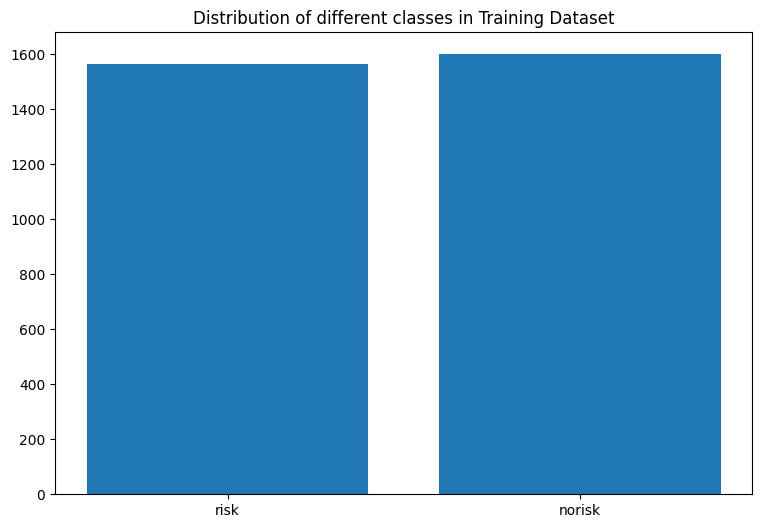

In [26]:
image_folder = ['risk', 'norisk']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir(os.getcwd() + '\\content\\train\\'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

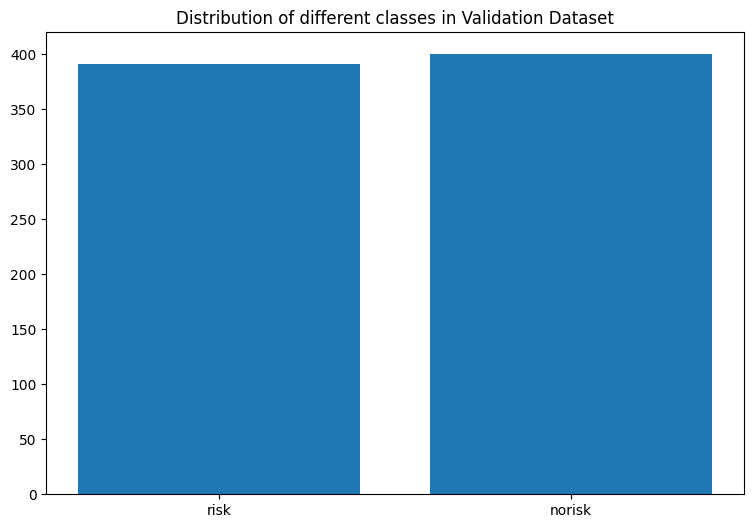

In [27]:
image_folder = ['risk', 'norisk']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir(os.getcwd() + '\\content\\validation\\'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Validation Dataset')
plt.show()

<h2>Fitting and predict</h2>

In [29]:
import ktrain
from ktrain import vision as vis

import warnings
warnings.filterwarnings('ignore')

# Imports scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score

In [30]:
(train_data, val_data, preproc) = vis.images_from_folder(
                                              datadir= os.getcwd() + '\\content\\',
                                              data_aug = vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'validation'],
                                              target_size=(64,64), color_mode='rgb')

Found 3163 images belonging to 2 classes.
Found 3163 images belonging to 2 classes.
Found 791 images belonging to 2 classes.


In [31]:
vis.print_image_classifiers()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

In [32]:
model = vis.image_classifier('pretrained_resnet50', train_data, val_data)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
pretrained_resnet50 model created.


In [33]:
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, use_multiprocessing=False, batch_size=16)

In [34]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
197/197 [==============================] - 24s 108ms/step - loss: 3.6659 - accuracy: 0.4303
Epoch 2/1024
197/197 [==============================] - 23s 114ms/step - loss: 3.4997 - accuracy: 0.4287
Epoch 3/1024
197/197 [==============================] - 22s 110ms/step - loss: 2.8035 - accuracy: 0.4655
Epoch 4/1024
197/197 [==============================] - 22s 111ms/step - loss: 1.7331 - accuracy: 0.6231
Epoch 5/1024
197/197 [==============================] - 21s 107ms/step - loss: 1.4765 - accuracy: 0.7058
Epoch 6/1024
197/197 [==============================] - 21s 108ms/step - loss: 5.6836 - accuracy: 0.6940
Epoch 7/1024
197/197 [==============================] - 2s 8ms/step - loss: 12.3078 - accuracy: 0.6917


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


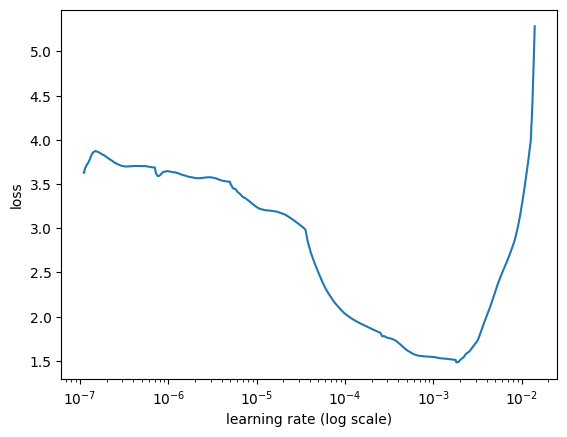

In [35]:
learner.lr_plot()

In [36]:
scale = (1e-2 - 1e-3)/2
print(scale)

0.0045000000000000005


In [37]:
learner.autofit(0.005)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.005...
Epoch 1/1024
198/198 [==============================] - 30s 140ms/step - loss: 3.9799 - accuracy: 0.6864 - val_loss: 2.6707 - val_accuracy: 0.7446
Epoch 2/1024
198/198 [==============================] - 27s 134ms/step - loss: 4.8792 - accuracy: 0.7215 - val_loss: 3.7365 - val_accuracy: 0.7636
Epoch 3/1024
198/198 [==============================] - ETA: 0s - loss: 5.7964 - accuracy: 0.7411
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0025 (if not early_stopping).
198/198 [==============================] - 27s 134ms/step - loss: 5.7964 - accuracy: 0.7411 - val_loss: 4.0874 - val_accuracy: 0.7737
Epoch 4/1024
198/198 [==============================] - 26s 133ms/step - loss: 4.7013 - accuracy: 0.7553 - val_loss: 2.6266 - val_accuracy: 0.7788
Epoch 5/1024
198/198 [=============================

In [38]:
# get a Predictor instance that wraps model and Preprocessor object
predictor = ktrain.get_predictor(learner.model, preproc)

In [39]:
# predict an image
predictor.predict_filename(os.getcwd() + '\\content\\validation\\risk\\ISIC_0024640.jpg')

['risk']